In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch, torch.nn as nn
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, auc

import Loader
import Judge
import time
from Models.GRU import Model as RNN
from Models.ResNet2 import Model as MLP
from Models.TOP import Model as TOP

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
LR = 0.0003
EPOCH = 150
n_fold = 8
TURN = 1
if_PRINT = True
if_valiSet = False

acc_list_total = []
best_roc_list, best_sen_list, best_spe_list = [], [], []
acc_TURN = []

in epoch 149, vali acc = 0.91 / 1.0(epoch:147) time: 15.3815s


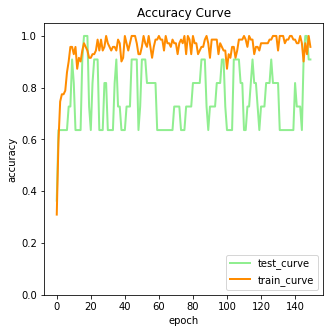

in epoch 149, vali acc = 0.55 / 0.82(epoch:138) time: 12.5103s


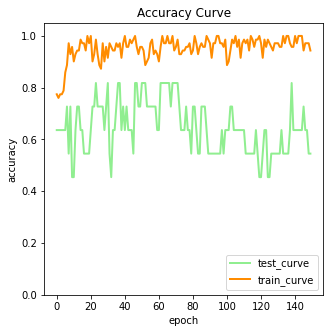

in epoch 149, vali acc = 0.9 / 0.93(epoch:148) time: 12.6113s


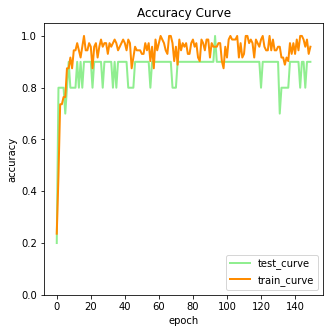

in epoch 149, vali acc = 0.8 / 1.0(epoch:16) time: 12.6514s
test sample in one class


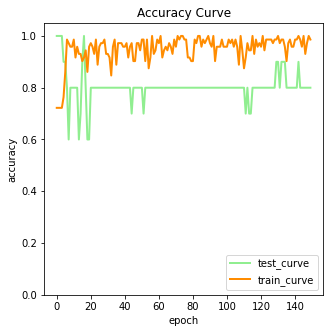

in epoch 149, vali acc = 0.8 / 0.9(epoch:120) time: 12.6044s


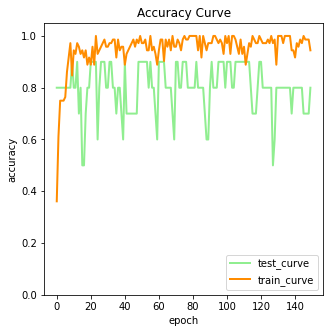

in epoch 149, vali acc = 0.9 / 0.9(epoch:148) time: 12.4241s


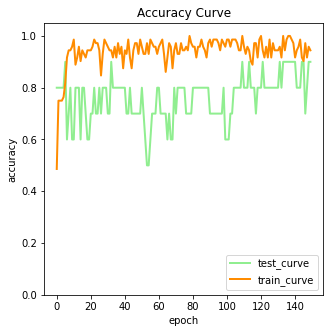

in epoch 149, vali acc = 1.0 / 1.0(epoch:148) time: 12.641s


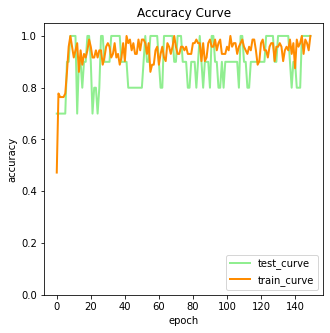

in epoch 149, vali acc = 0.8 / 0.93(epoch:141) time: 12.5788s


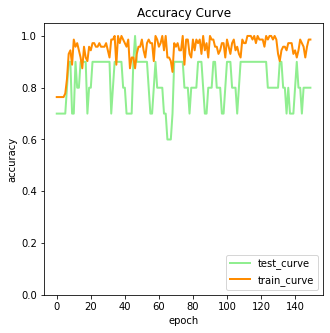

0.935606
roc:0.8531746031746034, sensitivity:0.7063492063492063, specificity:1.0


<Figure size 432x288 with 0 Axes>

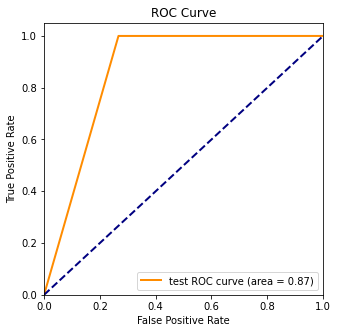

In [3]:
for turn in range(TURN):
    # I.准备数据
    DATA = Loader.Data(setNumber=3, fold=n_fold, valiSet=if_valiSet, batch_size=11)
    Fold_Datasets, test_iter = DATA.Fold_Datasets, DATA.Test_Iter

    _labels_list, _preds_list = [], [] # 用来画最后的ROC曲线
    acc_list_test = []
    for each_Fold in Fold_Datasets:
        time_ST = time.perf_counter()

        # 0.模型实例化
        model1 = RNN(90, 45, 2).to(device)
        model2 = MLP().to(device)
        model3 = TOP().to(device)

        loss_fn = nn.CrossEntropyLoss().to(device)
        optim = torch.optim.Adam(list(model2.parameters())+list(model3.parameters())+list(model1.parameters()), lr=LR)
        acc_list_turn = []

        # 1.作图需要的参数
        _X = []
        _Y_train = []
        _Y_test = []

        # 2.最终评价指标
        good_acc = [0, 0, 0]  # TODO: 增加
        good_con_mat = [None, None, None]
        good_epoch = 0
        good_preds_list, good_labels_list = [None, None, None], [None, None, None]


        # 3.数据集
        train_iter, vali_iter = each_Fold

        # 4.开始训练
        for i in range(EPOCH):

            # 4.1 ------TRAIN PART-------
            model1.train()
            model2.train()
            model3.train()

            acc_for_train, count = 0, 0
            for train_batch in train_iter:
                [samples_seq, samples_cor], labels = train_batch
                samples_seq, samples_cor, labels = samples_seq.to(device), samples_cor.to(device), labels.to(device)

                outputs_seq = model1(samples_seq)
                outputs_cor = model2(samples_cor)
                outputs = model3(outputs_seq, outputs_cor)
                # recording acc
                preds = outputs.argmax(1)
                acc = (preds == labels).sum()
                count += len(labels)
                acc_for_train += acc

                # loss computing, backward
                labels = labels.long()
                loss = loss_fn(outputs, labels)
                optim.zero_grad()
                loss.backward()
                optim.step()
            _Y_train.append(torch.true_divide(acc_for_train, count))
            _X.append(i)

            # 4.2 ------VALIDATION PART-------
            model1.eval()
            model2.eval()
            model3.eval()
            acc_for_vali, count = 0, 0
            con_mat_vali = np.zeros((2, 2))
            preds_list, labels_list = [], []
            for vali_batch in vali_iter:
                [samples_seq, samples_cor], labels = vali_batch

                samples_seq, samples_cor = samples_seq.to(device), samples_cor.to(device)
                outputs_seq = model1(samples_seq)
                outputs_cor = model2(samples_cor)
                outputs = model3(outputs_seq, outputs_cor)

                preds = outputs.cpu().argmax(1)
                preds_list += preds.tolist()
                labels_list += labels.tolist()
                acc = (preds == labels).sum()
                count += len(labels)
                acc_for_vali += acc

                for one in range(preds.shape[0]):
                    con_mat_vali[int(labels[one].item()), preds[one]] += 1

            _Y_test.append(torch.true_divide(acc_for_vali, count))

            # 4.2.1 打印总结
            print('\rin epoch {}, vali acc = {} / {}(epoch:{})'.format(i, round(float(torch.true_divide(acc_for_vali, count)), 2),
                                                                       round(float(np.mean(np.asarray(good_acc))), 2), good_epoch), end='')

            acc_list_turn.append(torch.true_divide(acc_for_vali, count))

            # 4.2.2 记录最好的值
            b_acc = min(good_acc)   # TODO: 修改
            ind_b_acc = good_acc.index(b_acc)
            if torch.true_divide(acc_for_vali, count) >= b_acc:
                good_acc[ind_b_acc] = torch.true_divide(acc_for_vali, count)
                good_con_mat[ind_b_acc] = con_mat_vali
                good_epoch = i
                good_labels_list[ind_b_acc] = labels_list
                good_preds_list[ind_b_acc] = preds_list

        time_ED = time.perf_counter()
        print(' time: {}s'.format(round((time_ED - time_ST), 4)))

        # 6.记录所有的评价参数
        good_roc = 0
        good_sensitivity = 0
        good_specificity = 0
        try:
            for i in range(len(good_acc)):  # TODO: 修改
                _preds_list += good_preds_list[i]
                _labels_list += good_labels_list[i]
                
                good_roc += Judge.mat_roc(good_con_mat[i].astype(dtype=int))
                good_sensitivity += Judge.mat_sensitivity(good_con_mat[i].astype(dtype=int))
                good_specificity += Judge.mat_specify(good_con_mat[i].astype(dtype=int))

            best_roc_list.append(good_roc / len(good_acc))
            best_sen_list.append(good_sensitivity / len(good_acc))
            best_spe_list.append(good_specificity / len(good_acc))
        except:
            print('test sample in one class')
        

        acc_list_test.append(np.mean(np.asarray(good_acc)))

        if if_PRINT:
            # plt
            plt.figure(figsize=(5, 5))
            plt.plot(_X, _Y_test, c='lightgreen', lw=2, label='test_curve')
            plt.plot(_X, _Y_train, c='darkorange', lw=2, label='train_curve')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.ylim([0, 1.05])
            plt.title('Accuracy Curve')
            plt.legend(loc="lower right")
            plt.show()

    # Fold结束，对所有fold的平均
    print(np.mean(np.asarray(acc_list_test)))
    print('roc:{}, sensitivity:{}, specificity:{}'.format(np.mean(np.asarray(best_roc_list)),
                                                          np.mean(np.asarray(best_sen_list)),
                                                          np.mean(np.asarray(best_spe_list))))
    acc_TURN.append(np.asarray(acc_list_test))

    Judge.auc_sens_spe_cal(_labels_list, _preds_list, draw='true')